In [13]:
from python_server_FCEUX import Server
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2

In [14]:
server = Server()

Waiting connection from emulator...
Connected:  <socket.socket fd=1780, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 12345), raddr=('127.0.0.1', 54466)>


LenImage: 40881


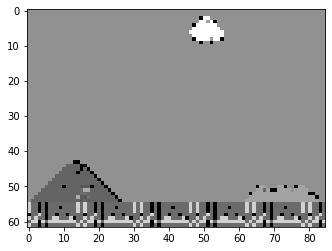

In [47]:
'''
Get pixeis image.
params: {(int) down_sample -> 1, (int) len_max_x -> 255, (int) len_max_y -> 239, (int) len_min_x -> 1,
(int) len_min_x -> 1, (bool) grayscale -> False}

'''
image = server.sendCommandAndReceiveOperation(json.dumps({'operation': 'getScreenShot',
          'params': {
              'grayscale': True,
              'down_sample': 3,
              'len_min_y': 45,
              'len_max_y': 230
          }
      }))
print('LenImage: {}'.format(len(image)))
printImage(image)

In [15]:
def printImage(image):
    a = image.decode()
    b = a.split('json')[1]
    c = json.loads(b)
    d = c['matriz']
    e = np.asarray(d)
    e
    plt.imshow(e, cmap='gray')
    plt.show()

In [16]:
'''
    Press Joypad
'''
import time
begin = time.time()
for i in range(200):
    try:
        image = server.sendCommandAndReceiveOperation(json.dumps({'operation': 'getScreenShot',
              'params': {
                  'grayscale': True,
                  'down_sample': 2,
                  'len_min_y': 45,
                  'len_max_y': 230
              }
          }))
        #printImage(image)
        server.sendCommandAndReceiveOperation(json.dumps({'operation': 'nextStep',
              'params': {
                  'press': 'right',
                  'screenshot_params': {
                      'grayscale': False,
                      'down_sample': 2,
                      'len_min_y': 45,
                      'len_max_y': 230
                  }
              }
        }))
    except:
        print('Except')
        break
    
end = time.time()
print(end - begin)


Except
19.479509830474854


In [52]:
for i in range(60):
    server.sendCommandAndReceiveOperation(json.dumps({'operation': 'pressJoypad',
          'params': {
              'press': 'A'
          }
      }))